In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Script context use	: This script uses Raymotime data (https://www.lasse.ufpa.br/raymobtime/) in the context of the UFPA - ITU Artificial Intelligence/Machine Learning in 5G Challenge (http://ai5gchallenge.ufpa.br/).
#Author       		: Ailton Oliveira, Aldebaro Klautau, Arthur Nascimento, Diego Gomes, Jamelly Ferreira, Walter Frazao
#Email          	: ml5gphy@gmail.com                                          
#License		: This script is distributed under "Public Domain" license.
###################################################################

#!/usr/bin/env python3
# -*- coding: utf-8 -*-

'''Trains a deep NN for choosing top-K beams
Adapted by AK: Aug 7, 2018
See
https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
and
https://stackoverflow.com/questions/45642077/do-i-need-to-use-one-hot-encoding-if-my-output-variable-is-binary
See for explanation about convnet and filters:
https://datascience.stackexchange.com/questions/16463/what-is-are-the-default-filters-used-by-keras-convolution2d
and
http://cs231n.github.io/convolutional-networks/
'''

import sys
sys.path.append('./drive/MyDrive/Colab Notebooks')

import csv
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.models import model_from_json,Model
from tensorflow.keras.layers import Dense,concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta,Adam
from sklearn.model_selection import train_test_split
from ModelHandler import ModelHandler
import numpy as np
import argparse


###############################################################################
# Support functions
###############################################################################

#For description about top-k, including the explanation on how they treat ties (which can be misleading
#if your classifier is outputting a lot of ties (e.g. all 0's will lead to high top-k)
#https://www.tensorflow.org/api_docs/python/tf/nn/in_top_k

def top_10_accuracy(y_true,y_pred):
    return metrics.top_k_categorical_accuracy(y_true,y_pred,k=10)

def top_30_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=30)

def top_50_accuracy(y_true,y_pred):
    return metrics.top_k_categorical_accuracy(y_true,y_pred,k=50)

def top_100_accuracy(y_true, y_pred):
    return metrics.top_k_categorical_accuracy(y_true, y_pred, k=100)


def sub2ind(array_shape, rows, cols):
    ind = rows*array_shape[1] + cols
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    return ind

def ind2sub(array_shape, ind):
    ind[ind < 0] = -1
    ind[ind >= array_shape[0]*array_shape[1]] = -1
    rows = (ind.astype('int') / array_shape[1])
    cols = ind % array_shape[1]
    return (rows, cols)

def beamsLogScale(y,thresholdBelowMax):
        y_shape = y.shape
        
        for i in range(0,y_shape[0]):            
            thisOutputs = y[i,:]
            logOut = 20*np.log10(thisOutputs + 1e-30)
            minValue = np.amax(logOut) - thresholdBelowMax
            zeroedValueIndices = logOut < minValue
            thisOutputs[zeroedValueIndices]=0
            thisOutputs = thisOutputs / sum(thisOutputs)
            y[i,:] = thisOutputs
        
        return y

def getBeamOutput(output_file):
    
    thresholdBelowMax = 60
    
    print("Reading dataset...", output_file)
    output_cache_file = np.load(output_file)
    yMatrix = output_cache_file['output_classification']
    
    yMatrix = np.abs(yMatrix)
    yMatrix /= np.max(yMatrix)
    yMatrixShape = yMatrix.shape
    num_classes = yMatrix.shape[1] * yMatrix.shape[2]
    
    y = yMatrix.reshape(yMatrix.shape[0],num_classes)
    y = beamsLogScale(y,thresholdBelowMax)
    
    return y,num_classes

###############################################################################
# Data configuration
###############################################################################
tf.device('/device:GPU:0')

coord = False
img = False
lidar = True

num_epochs = 160
batch_size = 32
tgtRec = 3
seed = 7

np.random.seed(seed)

if coord == True: 
    #train
    coord_train_input_file = '/content/drive/MyDrive/SSP_data/baseline_data/coord_input/coord_input.npz'
    coord_train_cache_file = np.load(coord_train_input_file)
    X_coord = coord_train_cache_file['coordinates']
    X_coord_train, X_coord_validation = train_test_split(X_coord, test_size=0.2, random_state=seed, shuffle=True)

    coord_train_input_shape = X_coord_train.shape

if img == True:
    resizeFac = 20 # Resize Factor
    nCh = 1 # The number of channels of the image
    imgDim = (360,640) # Image dimensions
    method = 1

    #train
    img_train_input_file = '/content/drive/MyDrive/SSP_data/baseline_data/image_input/img_input_20.npz'
    img_train_cache_file = np.load(img_train_input_file)
    X_img = img_train_cache_file['inputs']
    X_img_train, X_img_validation = train_test_split(X_img, test_size=0.2, random_state=seed, shuffle=True)
    print("Reading dataset... ",img_train_input_file)

    img_train_input_shape = X_img_train.shape

if lidar == True:
    #train
    lidar_train_input_file = '/content/drive/MyDrive/SSP_data/baseline_data/lidar_input/lidar_input.npz'
    lidar_train_cache_file = np.load(lidar_train_input_file)
    X_lidar = lidar_train_cache_file['input']
    X_lidar_train, X_lidar_validation = train_test_split(X_lidar, test_size=0.2, random_state=seed, shuffle=True)
    print("Reading dataset... ",lidar_train_input_file)
    lidar_train_input_shape = X_lidar_train.shape

###############################################################################
# Output configuration
#train
output_file = '/content/drive/MyDrive/SSP_data/baseline_data/beam_output/beams_output.npz'
y_output,num_classes = getBeamOutput(output_file)
y_train, y_validation = train_test_split(y_output, test_size=0.2, random_state=seed, shuffle=True)

##############################################################################
# Model configuration
##############################################################################

#multimodal
multimodal = [coord, img, lidar]
plot = True # Active Plot output

#validationFraction = 0.2 #from 0 to 1
modelHand = ModelHandler()
opt = Adam()

if coord:
    coord_model = modelHand.createArchitecture('coord_mlp',num_classes,coord_train_input_shape[1],'complete')
if img:
    if nCh==1:   
        img_model = modelHand.createArchitecture('light_image',num_classes,[img_train_input_shape[1],img_train_input_shape[2],1],'complete')
    else:
        img_model = modelHand.createArchitecture('light_image',num_classes,[img_train_input_shape[1],img_train_input_shape[2],img_train_input_shape[3]],'complete')
if lidar:
    lidar_model = modelHand.createArchitecture('lidar_marcus',num_classes,[lidar_train_input_shape[1],lidar_train_input_shape[2],lidar_train_input_shape[3]],'complete')

if sum(multimodal) == 2:
    if coord and lidar:
        combined_model = concatenate([coord_model.output,lidar_model.output])
        z = Dense(num_classes,activation="relu")(combined_model)
        model = Model(inputs=[coord_model.input,lidar_model.input],outputs=z)
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit([X_coord_train,X_lidar_train],y_train, 
        validation_data=([X_coord_validation, X_lidar_validation], y_validation),epochs=num_epochs,batch_size=batch_size)

    elif coord and img:
        combined_model = concatenate([coord_model.output,img_model.output])
        z = Dense(num_classes,activation="relu")(combined_model)
        model = Model(inputs=[coord_model.input,img_model.input],outputs=z)
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit([X_coord_train,X_img_train],y_train,
        validation_data=([X_coord_validation, X_img_validation], y_validation), epochs=num_epochs,batch_size=batch_size)
    
    else:
        combined_model = concatenate([lidar_model.output,img_model.output])
        z = Dense(num_classes,activation="relu")(combined_model)
        model = Model(inputs=[lidar_model.input,img_model.input],outputs=z)
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit([X_lidar_train,X_img_train],y_train, 
        validation_data=([X_lidar_validation, X_img_validation], y_validation), epochs=num_epochs,batch_size=batch_size)
elif sum(multimodal) == 3:
    combined_model = concatenate([lidar_model.output,img_model.output, coord_model.output])
    z = Dense(num_classes,activation="relu")(combined_model)
    model = Model(inputs=[lidar_model.input,img_model.input, coord_model.input],outputs=z)
    model.compile(loss=categorical_crossentropy,
                optimizer=opt,
                metrics=[metrics.categorical_accuracy,
                        metrics.top_k_categorical_accuracy,
                        top_10_accuracy,
                        top_30_accuracy,
                        top_50_accuracy,
                        top_100_accuracy])
    model.summary()
    hist = model.fit([X_lidar_train,X_img_train,X_coord_train],y_train,
            validation_data=([X_lidar_validation, X_img_validation, X_coord_validation], y_validation),
            epochs=num_epochs,batch_size=batch_size)

else:
    if coord:
        model = coord_model
        model.compile(loss=categorical_crossentropy,
                            optimizer=opt,
                            metrics=[metrics.categorical_accuracy,
                                    metrics.top_k_categorical_accuracy,
                                    top_10_accuracy,
                                    top_30_accuracy, 
                                    top_50_accuracy,
                                    top_100_accuracy])
        model.summary()
        hist = model.fit(X_coord_train,y_train, 
        validation_data=(X_coord_validation, y_validation),epochs=num_epochs,batch_size=batch_size)

    elif img:
        model = img_model  
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit(X_img_train,y_train, 
        validation_data=(X_img_validation, y_validation),epochs=num_epochs,batch_size=batch_size)

    else:
        model = lidar_model
        model.compile(loss=categorical_crossentropy,
                    optimizer=opt,
                    metrics=[metrics.categorical_accuracy,
                            metrics.top_k_categorical_accuracy,
                            top_10_accuracy,
                            top_30_accuracy,
                            top_50_accuracy,
                            top_100_accuracy])
        model.summary()
        hist = model.fit(X_lidar_train,y_train,epochs=num_epochs,batch_size=batch_size, validation_data=(X_lidar_validation, y_validation))

with open('history.txt', 'w') as f: 
       f.write(str(hist.history))


Reading dataset...  /content/drive/MyDrive/SSP_data/baseline_data/lidar_input/lidar_input.npz
Reading dataset... /content/drive/MyDrive/SSP_data/baseline_data/beam_output/beams_output.npz
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 200, 10)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 200, 10)       16910     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 200, 30)       36330     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 200, 25)       60775     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 200, 25)       0         
_________________________________________________________________
dropo

##Baselines cores

In [3]:
from scipy.special import softmax
beam_weights =  {}
for i in range(y_train.shape[1]):
	beam_weights[i] = 0

for i in range(y_train.shape[0]):
	scene_array = y_train[i,:]
	beam_weights[np.argmax(scene_array)] += 1

ocurrence = np.zeros((1,y_validation.shape[1]))
oc_factor = sum(beam_weights.values())
for b_index in beam_weights.keys():
	ocurrence[0,b_index] = beam_weights[b_index]/oc_factor
	
#ocurrence
ocurrence_input = np.repeat(ocurrence, y_validation.shape[0], axis=0)
ocurrence_output = softmax(ocurrence_input, axis=1)
#rand
rand_input = np.random.rand(2239,256)
rand_output = softmax(rand_input, axis=1)

#Accuracy / epochs

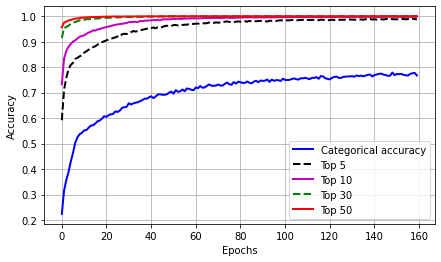

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(hist.history['categorical_accuracy'], 'b', label = 'Categorical accuracy', linewidth=2)
ax.plot(hist.history['top_k_categorical_accuracy'], 'k--', label = 'Top 5', linewidth=2)
ax.plot(hist.history['top_10_accuracy'], 'm', label = 'Top 10', linewidth=2)
ax.plot(hist.history['top_30_accuracy'], 'g--', label = 'Top 30', linewidth=2)
ax.plot(hist.history['top_50_accuracy'], 'r', label = 'Top 50', linewidth=2)
ax.set(xlabel='Epochs', ylabel='Accuracy')
ax.grid()
plt.legend()
#plt.title('LIDAR data')
plt.show()

##Creating Baselines

In [5]:
from keras.metrics import top_k_categorical_accuracy
predict_top_k = {}
ocurrence_top_k = {}
random_top_k = {}
y_predict = model.predict(X_lidar_validation)
for i in range(1,51):
  predict_top_k[f'top_{i}'] = np.sum(top_k_categorical_accuracy(y_validation,y_predict,k = i))/y_predict.shape[0]
  ocurrence_top_k[f'top_{i}'] = np.sum(top_k_categorical_accuracy(y_validation,ocurrence_output,k = i))/y_predict.shape[0]
  random_top_k[f'top_{i}'] = np.sum(top_k_categorical_accuracy(y_validation,rand_output,k = i))/y_predict.shape[0]

## TOP 10 acurracy

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
 array([-0.46159, -0.36159, -0.26159, -0.16159, -0.06159,  0.03841,
         0.13841,  0.23841,  0.33841,  0.43841,  0.53841]),
 <a list of 10 Patch objects>)

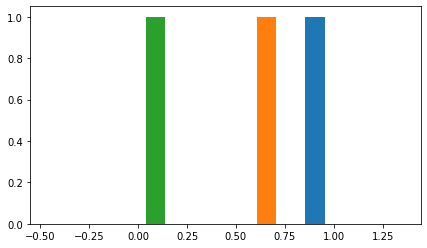

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 4))
plt.hist(predict_top_k['top_10'])
plt.hist(ocurrence_top_k['top_10'])
plt.hist(random_top_k['top_10'])

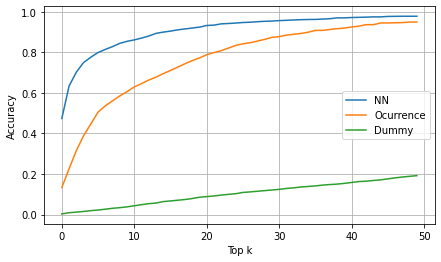

In [7]:
plt.figure(figsize=(7, 4))
plt.xlabel('Top k')
plt.ylabel('Accuracy')
plt.plot(list(predict_top_k.values()), label= 'NN')
plt.plot(list(ocurrence_top_k.values()), label = 'Ocurrence')
plt.plot(list(random_top_k.values()), label = 'Dummy')
plt.grid()
plt.legend()

# Save output

In [ ]:
fileNameIdentifier = '/content/drive/MyDrive/SSP_data/baseline_data/obstacles'
f = open(fileNameIdentifier + '.txt','w')
f.write(str(hist.history))
f.close()